In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import networkx as nx
from matplotlib.pyplot import *

def get_bouts(vox_times, ivi_thresh = 2, bout_length_thresh = 5):
    """
    Parameters: dt_start: ndarray
                        Array of vocalization times (s) since the start of the recording.
                ivi_thresh: int
                        Threshold for inter-vocalization-interval in seconds.
                bout_length_thresh: int
                        Threshold for number of vocalizations per bout.
    Returns:    bouts: Nx2 np.array
                        Bout onset (column 1)/offset (columns 2) indicies of vox_times, filtered by ISI and bout length.
                
    """
    #inter-vocalization-interval: how many seconds before me was a vocalization?
    ivi = np.insert(np.diff(vox_times), 0, 0) # add a 0 at the beginning to account for the array shortening
    
    #get onsets and offsets times (s) of vocalization bouts with IVIs < ivi_thresh
    onsets = np.where(np.insert(np.diff((ivi < ivi_thresh).astype('int')), 0, 1) == 1)[0]
    offsets = np.where(np.insert(np.diff((ivi < ivi_thresh).astype('int')), 0, 1) == -1)[0]-1
    onsets = onsets[:len(offsets)] #match onset/offset sizes
    
    #inclusive of t-1 and vocalizations in sequence
    bout_onsets = onsets[np.where(offsets-onsets > bout_length_thresh)[0]] - 1 
    bout_offsets = offsets[np.where(offsets-onsets > bout_length_thresh)[0]]
    
    bouts = np.array([bout_onsets, bout_offsets]).T
    
    return bouts

def get_tm(sequence):
    # Determine the number of unique states in the sequence
    unique_states = list(set(sequence))
    num_states = len(unique_states)

    # Initialize the transition count matrix with zeros
    transition_counts = np.zeros((num_states, num_states))

    # Count the transitions from each state to each other state
    for i in range(len(sequence) - 1):
        current_state = sequence[i]
        next_state = sequence[i + 1]
        current_index = unique_states.index(current_state)
        next_index = unique_states.index(next_state)
        transition_counts[current_index, next_index] += 1
        
    # Normalize the transition count matrix such that each row sums to 1
    row_sums = transition_counts.sum(axis=1)
    transition_matrix = transition_counts / row_sums[:, np.newaxis]
    
    return transition_matrix

def get_tm_bigram(sequence):
    # Determine the number of unique states in the sequence
    unique_states = list(set(sequence))
    num_states = len(unique_states)

    # Initialize the transition count matrix with zeros
    transition_counts = np.zeros((num_states, num_states))

    # Count the transitions from each state to each other state
    for i in range(len(sequence) - 1):
        current_state = sequence[i]
        next_state = sequence[i + 1]
        current_index = unique_states.index(current_state)
        next_index = unique_states.index(next_state)
        transition_counts[current_index, next_index] += 1
        
    #Normalize the transition count matrix such that each entry = bigram probability
    transition_matrix = transition_counts/np.sum(transition_counts) #bigram probabilities
    
    return transition_matrix


def draw_transition_graph(transition_matrix, edge_threshold=0.002,
                          node_threshold=0.002, node_size=200, arrow_size=10, 
                          edge_width=1, node_font_size=8,
                          width_scale=500,node_label_offset=10):
  
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes to the graph
    states = np.arange(transition_matrix.shape[0])
    G.add_nodes_from(states)
    
    # Add edges to the graph
    for i in range(transition_matrix.shape[0]):
        for j in range(transition_matrix.shape[1]):
            if i != j and transition_matrix[i,j] > edge_threshold:
                G.add_edge(states[i], states[j], weight=transition_matrix[i,j])

    # Set node positions
    pos = nx.circular_layout(G)
    
    # Offset the positions of the node labels
    pos_labels = {}
    for k, v in pos.items():
        x, y = v
        d = np.sqrt(x**2 + y**2)
        x = x / d * node_label_offset
        y = y / d * node_label_offset
        pos_labels[k] = (x, y)
    
    # Set edge weights proportional to bigram/transition probabilities
    edges = G.edges()
    weights = np.array([G[u][v]['weight'] for u, v in edges])*width_scale
    
    # set self-transition node widths proportional to self-transition probability
    self_probs = np.diag(transition_matrix)[np.array(G.nodes())]
    node_sizes = self_probs * (500*30)

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='white', edgecolors='black')
    nx.draw_networkx_labels(G, pos_labels, font_size=node_font_size, font_family='sans-serif')
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='black', 
                           arrowsize=arrow_size, width=weights,
                           connectionstyle='arc3, rad = .1')

    # Display the plot
    axis('off')
    axis('equal')

%matplotlib inline

In [14]:
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')

In [3]:
df = pd.read_feather('vocalization_df.feather')

df_c2 = df[df.cohort == 'c2']
df_c4 = df[df.cohort == 'c4']
df_c5 = df[df.cohort == 'c5']

In [4]:
bouts_c2 = get_bouts(df_c2.dt_start, ivi_thresh=2, bout_length_thresh=5)
bouts_c4 = get_bouts(df_c4.dt_start, ivi_thresh=2, bout_length_thresh=5)
bouts_c5 = get_bouts(df_c5.dt_start, ivi_thresh=2, bout_length_thresh=5)

In [6]:
#get cluster labels
z = df.groupby('z_70')['timestamp'].count().values
reorder = np.argsort(z)[::-1]

_c2_labels = df_c2.z_70.values
_c4_labels = df_c4.z_70.values
_c5_labels = df_c5.z_70.values
_all_labels = df.z_70.values

c2_labels = [np.where(reorder == _c2_labels[i])[0][0] for i in range(len(_c2_labels))]
c4_labels = [np.where(reorder == _c4_labels[i])[0][0] for i in range(len(_c4_labels))]
c5_labels = [np.where(reorder == _c5_labels[i])[0][0] for i in range(len(_c5_labels))]
all_labels = [np.where(reorder == _all_labels[i])[0][0] for i in range(len(_all_labels))]

In [8]:
#get transition matricies

c2_tm = get_tm(c2_labels)
c4_tm = get_tm(c4_labels)
c5_tm = get_tm(c5_labels)

all_tm = get_tm(all_labels)

Text(0.5, 1.0, 'Family 3')

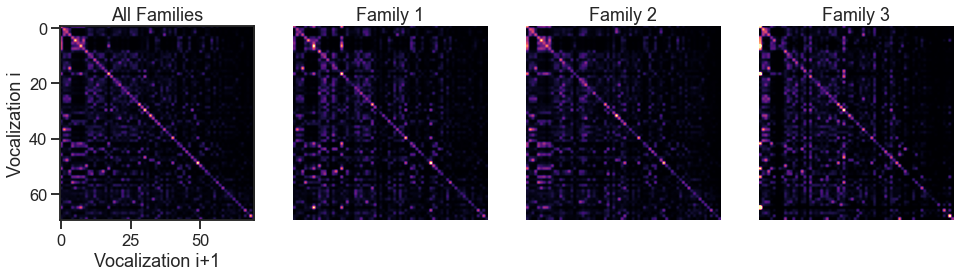

In [9]:
fig = figure(figsize=(16,6))

_clim = (.000, .25)
_cmap = 'magma'

subplot(1,4,1)
imshow(all_tm, cmap=_cmap, clim=_clim)
title('All Families')
ylabel('Vocalization i')
xlabel('Vocalization i+1')

subplot(1,4,2)
imshow(c2_tm, cmap=_cmap, clim=_clim)
axis('off')
title('Family 1')

subplot(1,4,3)
imshow(c4_tm, cmap=_cmap, clim=_clim)
axis('off')
title('Family 2')

subplot(1,4,4)
imshow(c5_tm, cmap=_cmap, clim=_clim)
axis('off')
title('Family 3')
# savefig('transition_probabilities.svg', dpi=300)

In [11]:
#get bigram probabilities
c2_tm_bigram = get_tm_bigram(c2_labels)
c4_tm_bigram = get_tm_bigram(c4_labels)
c5_tm_bigram = get_tm_bigram(c5_labels)

all_tm_bigram = get_tm_bigram(all_labels)

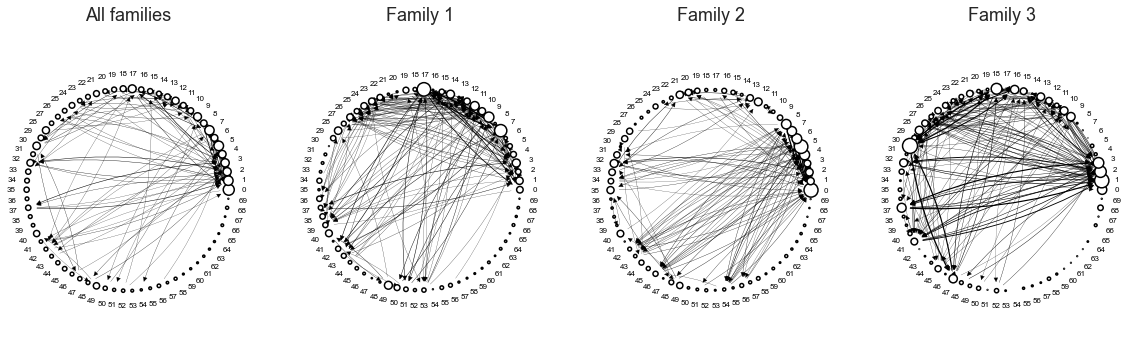

In [15]:
offset = 1.15
_width_scale = 200

figure(figsize=(20,6))
subplot(1,4,1)
draw_transition_graph(all_tm_bigram, 
                      node_label_offset=offset,
                      edge_threshold=0.001,
                      arrow_size=10,
                      width_scale=_width_scale)
title('All families')

subplot(1,4,2)
draw_transition_graph(c2_tm_bigram, 
                      node_label_offset=offset,
                      edge_threshold=0.001,
                      arrow_size=10,
                      width_scale=_width_scale)
title('Family 1')

subplot(1,4,3)
draw_transition_graph(c4_tm_bigram, 
                      node_label_offset=offset,
                      edge_threshold=0.001,
                      arrow_size=10,
                      width_scale=_width_scale)
title('Family 2')

subplot(1,4,4)
draw_transition_graph(c5_tm_bigram, 
                      node_label_offset=offset,
                      edge_threshold=0.001,
                      arrow_size=10,
                      width_scale=_width_scale)
title('Family 3');
# savefig('transition_graphs.svg', dpi=300)